In [18]:
import os
import random
import functools
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [24]:
# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label, size=300):
    with tf.device("/cpu:0"):
        img = tf.image.resize_with_pad(img, size, size)
        return img, label

In [25]:
total_num_classes = 196
training_classes = total_num_classes // 2 
examples_per_class_per_batch = 8
train_cls = random.sample(range(total_num_classes), k=training_classes)
classes_per_batch = 16 # max(16, training_classes)
target_img_size = 224  # Size of B0 image input

print(f"Class IDs seen during training {train_cls}")

def img_augmentation(img_batch, y, *args):
    # random resize and crop. Increase the size before we crop.
    img_batch = tf.keras.layers.RandomCrop(target_img_size, target_img_size)(img_batch)
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)
    return img_batch, y


# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cars196",
    splits="train",
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=300),
    class_list=train_cls,
    augmenter=img_augmentation,
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="test",
    total_examples_per_class=20,
    classes_per_batch=classes_per_batch,
    preprocess_fn=functools.partial(resize, size=300),
)

Class IDs seen during training [113, 106, 57, 108, 34, 101, 94, 168, 159, 144, 192, 88, 15, 189, 26, 177, 130, 166, 176, 78, 191, 151, 32, 51, 111, 103, 58, 100, 31, 47, 13, 50, 134, 155, 116, 4, 194, 167, 169, 165, 20, 81, 153, 86, 87, 145, 35, 160, 180, 188, 7, 49, 67, 120, 110, 129, 56, 158, 133, 39, 115, 16, 131, 172, 5, 98, 11, 42, 79, 148, 154, 52, 40, 117, 122, 66, 83, 71, 186, 61, 182, 36, 6, 60, 195, 29, 156, 55, 97, 10, 3, 92, 1, 28, 82, 93, 30, 163]


converting train:   0%|          | 0/8144 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/8144 [00:00<?, ?it/s]


The initial batch size is 128 (16 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8144 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/4106 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/4106 [00:00<?, ?it/s]

converting test:   0%|          | 0/3669 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3669 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3669 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/37 [00:00<?, ?it/s]

gather examples:   0%|          | 0/740 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/740 [00:00<?, ?it/s]

In [ ]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = test_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(20.0, 20.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice/255., y_slice):
    ax.imshow(im)
    ax.axis("off")

In [9]:
num_targets = 200
num_queries = 300
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, num_queries)
targets_x, targets_y = test_ds.get_slice(num_queries, num_targets)
# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    known_classes=tf.constant(train_cls),
    k=k,
)

callbacks = [
    val_loss,
]

In [13]:
embedding_size = 128  # @param {type:"integer"}

# building model
model = tfsim.architectures.EfficientNetSim(
    train_ds.example_shape, 
    embedding_size,
    pooling="gem",    # Can change to use `gem` -> GeneralizedMeanPooling2D
    gem_p=3.0,        # Increase the contrast between activations in the feature map.
)

In [14]:
epochs = 20
LR = 0.0001
steps_per_epoch = 100
val_steps = 50


# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)

# compiling and training
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/20
100/100 [==============================] - 33s 281ms/step - loss: 2.3432 - val_loss: 1.0508 - f1: 0.8152 - binary_accuracy: 0.6880
Epoch 2/20
100/100 [==============================] - 26s 257ms/step - loss: 2.3425 - val_loss: 1.0459 - f1: 0.8372 - binary_accuracy: 0.7200
Epoch 3/20
100/100 [==============================] - 26s 258ms/step - loss: 2.3462 - val_loss: 1.0504 - f1: 0.8426 - binary_accuracy: 0.7280
Epoch 4/20
100/100 [==============================] - 26s 257ms/step - loss: 2.3455 - val_loss: 1.0466 - f1: 0.8426 - binary_accuracy: 0.7280
Epoch 5/20
100/100 [==============================] - 26s 257ms/step - loss: 2.3433 - val_loss: 1.0545 - f1: 0.8426 - binary_accuracy: 0.7280
Epoch 6/20
100/100 [==============================] - 26s 256ms/step - loss: 2.3418 - val_loss: 1.0445 - f1: 0.8318 - binary_accuracy: 0.7120
Epoch 7/20
100/100 [==============================] - 26s 257ms/step -

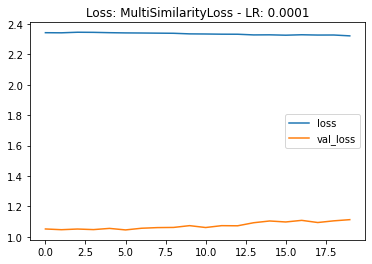

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()